# Projeto SCCON - Reconhecimento de Objetos com ML e transcrição de audio

### 0. Instalando as bibliotecas para o projeto

In [1]:


######################################################################################################################################
## Na primeira execução voce deve descomentar as linhas abaixo pois estes pacotes provavelmente não estão instalados em seu ambiente
######################################################################################################################################


#!pip install matplotlib
#!pip install moviepy
#!pip install SpeechRecognition
#!pip install pydub
#!pip install opencv-python

#!pip install ffmpeg-downloader
#!ffdl install --add-path


#!pip install astropy

#!pip install pandas


#!pip install mysql-connector-python-rf
#!pip install mysql-connector-python


#!pip install tensorflow 


#!pip install protobuf==5.29.5


############################################################################################
# Essas libs abaixo funcionam melhor fazendo o donload e colocando o executalve no PATH
###############################################################################################
#!pip install ffmpeg-downloader
#!ffdl install --add-path




   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ------------ --------------------------- 5.0/16.4 MB 50.1 MB/s eta 0:00:01
   ---------------------------------------  16.3/16.4 MB 65.2 MB/s eta 0:00:01
   ---------------------------------------- 16.4/16.4 MB 35.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Declarando as bibliotecas para o projeto

In [127]:
import numpy as np
import pandas as pd
import moviepy as mp
from moviepy import VideoFileClip
import speech_recognition as sr
import sys
from pydub import AudioSegment
import cv2
import os
from matplotlib import pyplot as plt


from PIL import Image
from astropy.io import fits


import tensorflow as tf




In [2]:
# Gerando o arquivo de requiments.txt - se primeira vez descomentar
#!pip freeze > requirements.txt

In [ ]:
# Para instalar as libs - se essa for a primeira vez
#!pip install -r requirements.txt

### 2. Separando os canais de audio do video

In [128]:
path = './video.mp4' 

# extraindo somenteo o canal de audio em formato mp3 - vamos salvar no diretorio corrente como nome somente_audio.mp3
clip = mp.VideoFileClip(path).subclipped(0, 40)
clip.audio.write_audiofile('./somente_audio.mp3')




MoviePy - Writing audio in ./somente_audio.mp3


MoviePy - Done.


### 3. Extraindo frames

In [129]:
import cv2
import os


# Carrega o video
cap = cv2.VideoCapture("video.mp4")

# conta quantos frames por segundo o video foi gravado
fps = cap.get(cv2.CAP_PROP_FPS)
print('Esse video foi gravado com taxa de ', round(fps), 'frames por segundo.')


# intervalo em segundos solicitado para a seleção do frama
interval_seconds = 0.10

# qtd total de frames quetem dentro do intevalo um decimo de segundo
qtd_frames_no_intervalo = int(interval_seconds * round(fps))
print('em cada intervamo de 0.10s teremos um total de', int(qtd_frames_no_intervalo), 'frames por intervalo de 0.10seg')
print('Portanto vamos selecionar todos os frames multiplos de 3 para se enquadrar no intervalo de 0.10 seg')


# cria uma pasta para guardar dos frames
try:
    if not os.path.exists('frames'):
        os.makedirs('frames')

except OSErrot:
    print('Não foi possível criar a pasta que vai armazenar os framees')

# sentinela para controlar o loop de varredura do video
currentframe = 0

# loop de varredura do video
while(True):
    ret,frame = cap.read()

    if ret:
        # se nao chegou ao final do video continua extraindo
        name = './frames/frame' + str(currentframe) + '.jpg'
        
        # salva as imagens SOMENTE SE O NUMERO DO FRAME É MULTIPLO DE 3 para cair na regra dos 0.10 segundos
        if(currentframe % 3 == 0):
            cv2.imwrite(name, frame)
            #print('Criando..' + name)

        # incrementa a sentinela
        currentframe += 1
    else:
        break

# Limpara todo o espaço usado no buffer de memória
cap.release()
cv2.destroyAllWindows()

        
        



Esse video foi gravado com taxa de  30 frames por segundo.
em cada intervamo de 0.10s teremos um total de 3 frames por intervalo de 0.10seg
Portanto vamos selecionar todos os frames multiplos de 3 para se enquadrar no intervalo de 0.10 seg


####  3.1. Gerando imagens do tipo FITS e editanto os headers

In [130]:
# Aqui vamos criar uma função de conversão de JPG para FITS e deixa-la em memoria para chamadas poteriores

from PIL import Image
import numpy as np
from astropy.io import fits



def jpg_to_fits(jpg_path, fits_path):
    """
    Converts a JPEG image to a FITS file.

    Args:
        jpg_path (str): The path to the input JPEG file.
        fits_path (str): The path to save the output FITS file.
    """
    try:
        # Load the JPEG image
        img = Image.open(jpg_path).convert('L')

        # Convert to grayscale NumPy array (FITS typically stores grayscale data)
        # If you need to preserve color, you'd handle channels separately or use a specialized approach.
        image_data = np.array(img)

        # Create a PrimaryHDU from the image data
        hdu = fits.PrimaryHDU(image_data)


        # Gerando e editando os headers
        hdu.header['IMGTYPE'] = 'Grayscale Image'
        hdu.header['DATE-OBS'] = '2025-05-13T08:24:08.310'
        hdu.header['OBSERVER'] = 'Robson Tavares Nonato'         
        hdu.header['ORIGIN'] = 'Python Conversion'
        hdu.header['OBJECT'] = 'Projeto SCCON'
        hdu.header['EXPTIME'] = '120'
        hdu.header['RECORD-ID'] = 'ID_FRAME_' + str(id_frame)                     
        # Add a new keyword with a comment
        hdu.header['COMMENT'] = ('Convertido de um JPG', 'Imagem de testes de projeto de detecção de imagens')
            
        

        # Create an HDUList and append the HDU
        hdul = fits.HDUList([hdu])


        # Save the FITS file
        hdul.writeto(fits_path, overwrite=True)
        print(f"Successfully converted '{jpg_path}' to '{fits_path}'")

    except FileNotFoundError:
        print(f"Error: File not found at '{jpg_path}'")
    except Exception as e:
        print(f"An error occurred: {e}")



# teste da chamada da função de conversao
jpg_to_fits('./frames/frame0.jpg', './fits/frame0.fits')

# verifivando o conteudo do arquivo FITS
file = fits.open('./fits/frame0.fits')
file.info()


An error occurred: name 'id_frame' is not defined
Filename: ./fits/frame0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (848, 480)   uint8   


####  3.2. Visualizando a imagens do tipo FITS após edição do header

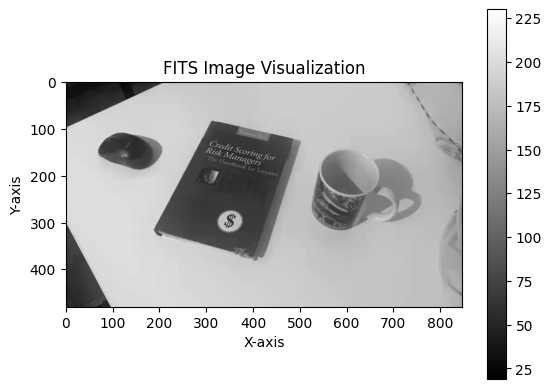

In [46]:
# Visualizando uma imagem do tipo FITS
from astropy.io import fits
import matplotlib.pyplot as plt

# Open the FITS file
hdu_list = fits.open('./fits/frame0.fits')
# Access the image data (usually in the primary HDU)
image_data = hdu_list[0].data
# Close the FITS file
hdu_list.close()


plt.imshow(image_data, cmap='gray')
plt.colorbar() # Add a color bar to indicate data values
plt.title('FITS Image Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()



### 3.5. Conectando ao Banco de Dados MySQL

In [106]:
# Conectando ao Banco de Dados Mysql

# Antes de fazer a conexão é necessario ajustar o plugin de encriptamento de senha dentro do Banco de Dados
# Acesse o phpMyAdmin com o usuario root e insira o seguinte comando
# ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY '{NewPassword}';
# você pode mandar o mesma senha que esta logo abaixo que foi configurada no container docker... no arquivo que esta na raiz desse projeto .yml


import mysql.connector
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    password='your_root_password',
    database='your_database_name',
    auth_plugin='mysql_native_password' # Specify the plugin
)

# aqui vamos colocar o parametros buffered igual a verdadeiro para colocar as querys em buffer a fim de evitar sobreposição de envio
mycursor = mydb.cursor(buffered=True)


In [110]:
# 3.5.1. Deletando a tabela caso se ela existir
sql_cria_tabela_vazia = 'DROP TABLE IF EXISTS fits_data'
mycursor.execute(sql_cria_tabela_vazia)
mydb.commit()


In [111]:
# 3.5.2. Criando a tabela vazia com a estrutura
# ATENÇÃO: aqui tivemos que usar o tipo LONGBLOB para o campo que vai receber a imagem pois tipo BLOB não aguenta
sql_cria_tabela_vazia = 'CREATE TABLE fits_data (id INT AUTO_INCREMENT PRIMARY KEY,filename VARCHAR(255),img_tipo VARCHAR(255),date_obs VARCHAR(255),observador VARCHAR(120),origem VARCHAR(120),objeto VARCHAR(120),exp_time VARCHAR(60),record_id VARCHAR(120),comentario VARCHAR(120),image_data LONGBLOB)';
mycursor.execute(sql_cria_tabela_vazia)
mydb.commit()




In [113]:
# Lendo o arquivo FITS a partir do disco

from astropy.io import fits

hdul = fits.open('./fits/frame0.fits')
header = hdul[0].header  # Access the primary HDU header
data = hdul[0].data    # Access the primary HDU data (e.g., image array)

In [114]:
# 3.5.3. Inserindo registros referente a imagem FITS

#sql = "INSERT INTO fits_data (filename,img_tipo,date_obs,observador,origem,objeto,exp_time,record_id,comentario,image_data) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
sql = "INSERT INTO fits_data (filename,img_tipo,date_obs,image_data) VALUES (%s, %s, %s, %s)"
val = (hdul.filename(), header['NAXIS'], header['BITPIX'], data.tobytes())
mycursor.execute(sql, val)

# note que para fazer o insert também é necessário fazer o commit
mydb.commit()


In [ ]:
# 3.5.4. Desconectando do BD e liberando o buffer
hdul.close()
mycursor.close()
mydb.close()


In [120]:
# 3.5.4. Automatizando as Querys - Função que Faz Conexão ao BD e traz imagens armazenadas do campo BLOB

import mysql.connector


def write_file(data, filename):
    # Convert binary data to proper format and write it on Hard Disk
    with open(filename, 'wb') as file:
        file.write(data)


def readBLOB(emp_id, photo):
    print("Reading BLOB data from MySQL table")

    try:
        connection = mysql.connector.connect(host='localhost',
                                             database='your_database_name',
                                             user='root',
                                             password='your_root_password')

        cursor = connection.cursor()
        sql_fetch_blob_query = """SELECT id,filename,img_tipo,date_obs,image_data FROM fits_data where id = %s"""

        cursor.execute(sql_fetch_blob_query, (emp_id,))
        record = cursor.fetchall()
        for row in record:
            print("Id = ", row[0], )
            print("Nome_Arquivo = ", row[1])
            print("Tipo_Imagem = ", row[2])
            print("Data_Geracao = ", row[3])
            image = row[4]          
            print("Salva o BLOB do BD para o disco \n")
            write_file(image, photo)
            
    except mysql.connector.Error as error:
        print("Failed to read BLOB data from MySQL table {}".format(error))

    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            print("MySQL connection is closed")


# Chamada da Funcao de busca da imagem no BD - recebe dois parametros: o id do frame e também o caminho de destino do arquivo em disco
readBLOB(1, "./fits_from_bd/frame_frombd_1.fits")



Reading BLOB data from MySQL table
Id =  1
Nome_Arquivo =  ./fits/frame0.fits
Tipo_Imagem =  2
Data_Geracao =  8
Salva o BLOB do BD para o disco 

MySQL connection is closed


In [123]:
# 3.5.5. Analisando a qualidade da imagem recuperda o BD para verificar se não houve corrupção do arquivo da consulta

try:
    with fits.open('./fits_from_bd/frame_frombd_1.fits', ignore_missing_simple=True) as hdul:
        # Process the FITS data here
        print(hdul.info())
except OSError as e:
    print(f"Error opening FITS file: {e}")

Error opening FITS file: Empty or corrupt FITS file


        Use textwrap.indent() instead. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 407040
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


###  4. Exibindo o Histograma e Fazendo a Equalização

C:\Users\USER\AppData\Local\Temp\ipykernel_19536\3775307122.py:9: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.hist(img.ravel(), 256, [0, 256])


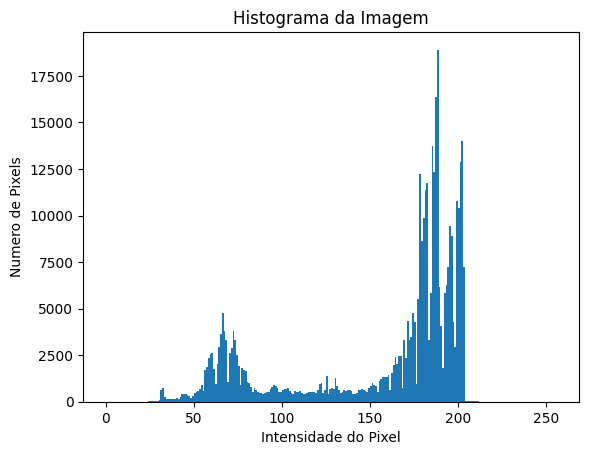

In [131]:
# 4.1 Carregando a imagem em escala de cinza
img = cv2.imread('./frames/frame0.jpg', 0)

#  Calculando ohistograma usando o método cv2.calcHist()
hist = cv2.calcHist([img], [0], None, [256], [0, 256])


# Plotando o histogrma com PyPlot plt.hist()
plt.hist(img.ravel(), 256, [0, 256])
plt.title('Histograma da Imagem')
plt.xlabel('Intensidade do Pixel')
plt.ylabel('Numero de Pixels')
plt.show()

#### 4.1. Histograma após Equalização

C:\Users\USER\AppData\Local\Temp\ipykernel_19536\2424907093.py:11: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.hist(equalized_image_cv.ravel(), 256, [0, 256])


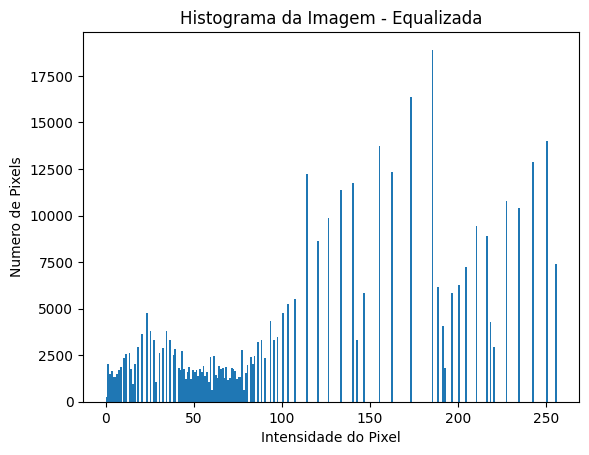

In [132]:
# 4.1. Aqui vamos equalizar o histograma e fazer a exibição da versão equalizada

# Faz a equalização do histograma 
equalized_image_cv = cv2.equalizeHist(img)

#  Calculando o histograma EQUALIZADO usando o método cv2.calcHist()
hist = cv2.calcHist([equalized_image_cv], [0], None, [256], [0, 256])


# Plotando o histogrma com PyPlot plt.hist()
plt.hist(equalized_image_cv.ravel(), 256, [0, 256])
plt.title('Histograma da Imagem - Equalizada')
plt.xlabel('Intensidade do Pixel')
plt.ylabel('Numero de Pixels')
plt.show()

###  5. Usando o modelo de reconhecimento de objetos feito em TensorFlow

In [9]:


# Carregar modelo SSD MobileNet V2 pré-treinado do TensorFlow Hub
#MODEL = tf.saved_model.load("http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz")

MODEL = tf.saved_model.load("./modelodetec/saved_model")



# Lista de classes COCO
class_names = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]


# Função de detecção
def detect_objects(frame):

    input_tensor = tf.convert_to_tensor([frame])
    input_tensor = tf.cast(input_tensor, tf.uint8)   
     
    # For a grayscale image (adding a single channel dimension)
    input_tensor = tf.expand_dims(input_tensor, axis=-1)

    # If an RGB image is expected and the input is grayscale, it might need
    # to be converted or replicated across 3 channels.
    # Example for converting grayscale to 3 channels (not always appropriate)
    input_tensor = tf.image.grayscale_to_rgb(input_tensor)

    
    detections = MODEL(input_tensor)

    # Extração dos dados
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    classes = detections['detection_classes'][0].numpy().astype(int)

    return boxes, scores, classes


# Abrir webcam
#cap = cv2.VideoCapture(0)
#cap = cv2.VideoCapture("video.mp4")


# Load the JPEG image
img = Image.open('./frames/frame0.jpg').convert('L')
# Convert to grayscale NumPy array (FITS typically stores grayscale data)
# If you need to preserve color, you'd handle channels separately or use a specialized approach.
image_data = np.array(img)


frame = image_data
height = 20
width = 20 

input_frame = cv2.resize(frame, (320, 320))
input_frame = input_frame / 255.0  # normalizar



boxes, scores, classes = detect_objects(input_frame)
print(boxes) 
print(classes)
print(scores)





for i in range(len(scores)):
    if scores[i] > 0.5:
        y1, x1, y2, x2 = boxes[i]
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)
        
        label = class_names[classes[i] - 1]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        print('Aqui vai o  label possivel', label)



    

# Exibe o frame
#cv2.imshow('Detecta os Objetos', frame)

#cv2.destroyAllWindows()



[[0.00000000e+00 3.13074589e-02 9.78279591e-01 9.57943380e-01]
 [7.05508888e-02 5.30125201e-02 9.15024519e-01 9.37169671e-01]
 [0.00000000e+00 2.69002318e-02 9.69369173e-01 9.78238761e-01]
 [7.05508888e-02 5.30125201e-02 9.15024519e-01 9.37169671e-01]
 [2.48280853e-01 7.14978874e-02 8.78656387e-01 8.83535743e-01]
 [2.05916226e-01 6.52808249e-02 9.11212981e-01 8.77139211e-01]
 [2.83881128e-02 4.96443510e-02 9.54194069e-01 7.53481567e-01]
 [1.65235400e-01 7.22506583e-01 2.51501769e-01 9.08566296e-01]
 [1.42081738e-01 1.47257149e-02 9.27245617e-01 9.65133667e-01]
 [8.45210850e-02 2.97170877e-02 9.72102880e-01 6.13578916e-01]
 [7.90509403e-01 6.19638741e-01 1.00000000e+00 7.09298909e-01]
 [0.00000000e+00 2.69002318e-02 9.69369173e-01 9.78238761e-01]
 [7.83656836e-01 5.90423524e-01 1.00000000e+00 6.86077058e-01]
 [2.83881128e-02 4.96443510e-02 9.54194069e-01 7.53481567e-01]
 [6.20797276e-02 6.53236210e-02 9.36324120e-01 9.29672360e-01]
 [0.00000000e+00 1.01919502e-01 9.72765505e-01 9.754358

#### 5.1. Aqui vamos fazer o teste da função de detecção em um VIDEO ou em uma WEBCAM

In [126]:


# Carregar modelo SSD MobileNet V2 pré-treinado do TensorFlow Hub
#MODEL = tf.saved_model.load("http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz")
MODEL = tf.saved_model.load("./modelodetec/saved_model")

# Lista de classes COCO
class_names = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]



# Função de detecção
def detect_objects(frame):

    input_tensor = tf.convert_to_tensor([frame])
    input_tensor = tf.cast(input_tensor, tf.uint8)   
     
    # For a grayscale image (adding a single channel dimension)
    #input_tensor = tf.expand_dims(input_tensor, axis=-1)

    # If an RGB image is expected and the input is grayscale, it might need
    # to be converted or replicated across 3 channels.
    # Example for converting grayscale to 3 channels (not always appropriate)
    #input_tensor = tf.image.grayscale_to_rgb(input_tensor)

    
    detections = MODEL(input_tensor)

    # Extração dos dados
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    classes = detections['detection_classes'][0].numpy().astype(int)

    return boxes, scores, classes




# Abrir webcam
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture("video.mp4")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    height, width, _ = frame.shape
    input_frame = cv2.resize(frame, (320, 320))
    input_frame = input_frame / 255.0  # normalizar
    boxes, scores, classes = detect_objects(input_frame)

    for i in range(len(scores)):
        if scores[i] > 0.5:
            y1, x1, y2, x2 = boxes[i]
            x1 = int(x1 * width)
            y1 = int(y1 * height)
            x2 = int(x2 * width)
            y2 = int(y2 * height)

            label = class_names[classes[i] - 1]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow('Detecta os Objetos', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()





NameError: name 'tf' is not defined

### 6. Fazendo a transcrição do audio

In [6]:
# carregando o canal de audio em mp3
src=(r"./somente_audio.mp3")


# converter de mp3 para wav
sound = AudioSegment.from_mp3(src)
sound.export("somente_audio.wav", format="wav")
file_audio = sr.AudioFile("somente_audio.wav")


# Usar o audio em WAV para a lib de transcricao 
r = sr.Recognizer()
with file_audio as source:
   audio_text = r.record(source)
   text = r.recognize_google(audio_text,language='pt-BR')


print('-----------------------------------------------------------------')
print('::Confira aqui o texto extraido do audio : ', text)
print('-----------------------------------------------------------------')


-----------------------------------------------------------------
::Confira aqui o texto extraido do audio :  gravação do vídeo para o projeto da SC com reconhecimento de objetos utilizando machine learning aqui em cima desta mesa nós temos um mouse um livro e temos uma caneca a ideia desse projeto é separar os canais de áudio e vídeo transcrever o arquivo de áudio texto usando espírito Tex e desenvolver um algoritmo machine learning que classifica os objetos presentes no vídeo e atribui lei dos princípios objetos vamos em frente
-----------------------------------------------------------------


### 7. Funções Auxiliares do Projeto

In [134]:
# Aqui vamos criar uma função de conversão de JPG para FITS e deixa-la em memoria para chamadas poteriores

from PIL import Image
import numpy as np
from astropy.io import fits



def jpg_to_fits(jpg_path, fits_path):
    """
    Converts a JPEG image to a FITS file.

    Args:
        jpg_path (str): The path to the input JPEG file.
        fits_path (str): The path to save the output FITS file.
    """
    try:
        # Load the JPEG image
        img = Image.open(jpg_path).convert('L')

        # Convert to grayscale NumPy array (FITS typically stores grayscale data)
        # If you need to preserve color, you'd handle channels separately or use a specialized approach.
        image_data = np.array(img)

        # Create a PrimaryHDU from the image data
        hdu = fits.PrimaryHDU(image_data)


        # Gerando e editando os headers
        hdu.header['IMGTYPE'] = 'Grayscale Image'
        hdu.header['DATE-OBS'] = '2025-05-13T08:24:08.310'
        hdu.header['OBSERVER'] = 'Robson Tavares Nonato'         
        hdu.header['ORIGIN'] = 'Python Conversion'
        hdu.header['OBJECT'] = 'Projeto SCCON'
        hdu.header['EXPTIME'] = '120'
        hdu.header['RECORD-ID'] = 'ID_FRAME_' + str(id_frame)                     
        # Add a new keyword with a comment
        hdu.header['COMMENT'] = ('Convertido de um JPG', 'Imagem de testes de projeto de detecção de imagens')
            
        

        # Create an HDUList and append the HDU
        hdul = fits.HDUList([hdu])


        # Save the FITS file
        hdul.writeto(fits_path, overwrite=True)
        print(f"Successfully converted '{jpg_path}' to '{fits_path}'")

    except FileNotFoundError:
        print(f"Error: File not found at '{jpg_path}'")
    except Exception as e:
        print(f"An error occurred: {e}")



# teste da chamada da função de conversao
jpg_to_fits('./frames/frame0.jpg', './fits/frame0.fits')

# verifivando o conteudo do arquivo FITS
file = fits.open('./fits/frame0.fits')
file.info()





An error occurred: name 'id_frame' is not defined
Filename: ./fits/frame0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (848, 480)   uint8   
